sitter reviews from homeowners - exploratory data analysis
===
# introduction
this notebook is solely for the purposes of getting to know the data and discovering its shapes and secrets. data cleaning and preprocessing takes place further downstream from here.


In [1]:
from datetime import datetime
import duckdb
import matplotlib as plt
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import ydata_profiling as yp

DATAFOLDER='../data/raw/'        # path to raw data files
DATABASEFILE='../data/sits.ddb'  # path to persistent duckdb database file

In [2]:
np.finfo(np.float16).max

65500.0

# housesitter reviews
in this data set, each row represents a homeowner's review of a housesitter. from the data dictionary, we can learn a lot about the columns included. 
many of the columns are boolean, some are datetimes, others are strings, that can either be interpreted as categorical variables or harvested for one-hot encoded variables. 

## assumption
for each boolean variable, if an answer is missing, we will interpret that as FALSE, i.e. we take the question to mean whether _they are confirmed to be true_ or not. this assumption is not always going to be true, but it will be more often than not, and increases the expressiveness of the data set. 

In [3]:
bool_cols = [
]
date_columns = [
    'review_ts',
    'reply_ts'
]
today = pd.Timestamp.now().floor('D')  # Floor to remove time component


category_cols=[
]
# numerical columns
data_types = {
    'assignment_id':np.uint32,
    'avg_score':np.int8,
    'id':np.uint32,
    'listing_id':np.uint32,
    'organised':np.uint32,
    'overall_score':np.float32,
    'owner_user_id':np.uint32,
    'pet_care':np.int8,
    'self_sufficient':np.int8,
    'sitter_user_id':np.uint32,
    'tidy':np.int8,
    
}


In [4]:
reviews_df =  (
    pd.read_csv(
        DATAFOLDER+'reviews.csv', 
        low_memory=False,
        parse_dates=date_columns,
        date_format='%Y-%m-%d %H:%M:%S.%f',
        dtype=data_types
    )
)
display(reviews_df.sample(5))
display(reviews_df.info())

# reviews_df['birth_decade'].unique()
# reviews_df['five_star_ratio'].isna().sum()
# reviews_df['five_star_ratio'].value_counts()
# reviews_df[reviews_df['days_since_modified']>2000]
# reviews_df['five_star_ratio'].max()
# reviews_df[reviews_df['five_star_ratio']>0.99][['five_star_ratio', 'nb_5s_reviews', 'nb_reviews']]

,assignment_id,avg_score,id,listing_id,organised,overall_score,owner_user_id,pet_care,profile_id,reliable,reply_ts,requested,review_ts,self_sufficient,sitter_user_id,tidy
11179,502058,5,186167,195663,5,5.0,692557,5,1633180,5,NaT,True,2022-03-09 19:59:43,5,2538628,5
55748,681112,5,251867,684223,5,5.0,3257967,5,2583370,5,NaT,False,2022-11-28 00:05:09,5,4498897,5
51579,594670,5,234806,880732,5,5.0,3913468,5,2118464,5,NaT,False,2022-09-27 18:04:29,5,3557475,5
90480,675768,5,280753,1091577,5,5.0,4807220,5,1866824,5,2023-03-07 21:16:49,False,2023-03-07 21:01:11,5,2993812,5
48609,658791,5,245416,666930,5,5.0,3191798,5,2443392,5,NaT,True,2022-11-01 21:09:57,5,4231704,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95646 entries, 0 to 95645
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   assignment_id    95646 non-null  uint32        
 1   avg_score        95646 non-null  int8          
 2   id               95646 non-null  uint32        
 3   listing_id       95646 non-null  uint32        
 4   organised        95646 non-null  uint32        
 5   overall_score    95363 non-null  float32       
 6   owner_user_id    95646 non-null  uint32        
 7   pet_care         95646 non-null  int8          
 8   profile_id       95646 non-null  int64         
 9   reliable         95646 non-null  int64         
 10  reply_ts         20837 non-null  datetime64[ns]
 11  requested        95646 non-null  bool          
 12  review_ts        95646 non-null  datetime64[ns]
 13  self_sufficient  95646 non-null  int8          
 14  sitter_user_id   95646 non-null  uint3

None

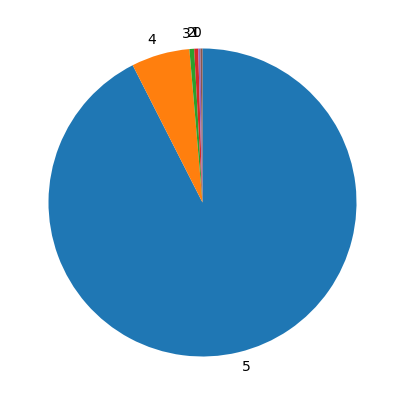

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
plt.pie(reviews_df['avg_score'].value_counts(), startangle=90, counterclock=False, labels=['5','4','3','2','1', '0'])
plt.show()

In [6]:
user_review_summary_df = (
    reviews_df
    .groupby('sitter_user_id')
    .agg({
        'id':'count',
        'assignment_id':
        'nunique',
        'overall_score':'mean',
        'tidy':'mean',
        'organised':'mean'
    })
    .rename(columns={
        'id':'num_reviews',
        'assignment_id':'num_assignments',
        'overall_score':'mean_score',
        'tidy':'tidiness_avg',
        'organised':'organised_avg',
    })
)

user_review_summary_df[user_review_summary_df['num_reviews']>7].sort_values('mean_score', ascending=True)
# user_review_summary_df.info()

,num_reviews,num_assignments,mean_score,tidiness_avg,organised_avg
sitter_user_id,,,,,
2808091,9,9,3.333333,3.111111,3.111111
1441093,11,11,3.727273,3.545455,3.727273
3479858,12,12,4.166667,4.250000,4.083333
3114610,8,8,4.250000,4.375000,4.250000
1700238,8,8,4.375000,3.875000,4.250000
...,...,...,...,...,...
1620426,10,10,5.000000,5.000000,5.000000
1626664,10,10,5.000000,4.500000,4.500000
1628692,12,12,5.000000,5.000000,5.000000


# save prepped data to database

In [ ]:
with duckdb.connect(DATABASEFILE) as con:
    con.sql("DROP TABLE IF EXISTS review_prep")
    con.sql("CREATE TABLE review_prep AS SELECT * FROM reviews_df")
    con.sql("SELECT COUNT(*) FROM review_prep")

In [ ]:
with duckdb.connect(DATABASEFILE) as con:
    con.sql("DROP TABLE IF EXISTS user_review_summary")
    con.sql("CREATE TABLE user_review_summary AS SELECT * FROM user_review_summary_df")
    con.sql("SELECT COUNT(*) FROM user_review_summary")

# exploratory data analysis reporting

In [8]:
profile = yp.ProfileReport(reviews_df)
profile.to_file('../notes/eda/eda_report_reviews.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile = yp.ProfileReport(user_review_summary)
profile.to_file('../notes/eda/eda_report_review_summary.html')

# lessons from exploratory analysis report
- grade inflation, almost everyone is highly rated.
- a small number of reviews below 4 stars is not usefully clustered